In [295]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import scipy.stats as stats

In [296]:
#df_MMRT = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRT.csv')

df_MMRTNE = pd.read_csv('../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv')
df_OECD = pd.read_csv('../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv')

In [297]:
# select which df to use 

df = df_MMRTNE
indicator_y = 'SH.STA.MMRT.NE'

#df = df_MMRT
#indicator_y = 'SH.STA.MMRT'

#df = df_OECD
#indicator_y = 'MATIMATM'

# Perform hyperparameter tuning? 
perform_hp_tuning = True

In [298]:
# First need to encode the country 

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep = True)
data_encoded['Country'] = country_encoder.fit_transform(data_encoded['Country'])

### Random Forest

In [299]:
# pull out Maternal Mortality as the predictor variable 
X = data_encoded.drop(columns= indicator_y)
y = data_encoded[indicator_y]

### Hyperparameter Tuning

In [300]:
if perform_hp_tuning:   

    # Create a Random Forest Regressor
    rf_regressor = RandomForestRegressor(random_state=42)

    # Define a grid of hyperparameters to search
    parameter_grid = {
        'n_estimators': [10, 20, 40],           
        'max_depth': [None, 10, 20, 30, 40, 50],         
        'min_samples_split': [2, 5, 10, 20],         
        'min_samples_leaf': [1, 2, 4, 6, 10, 20],                   
        'bootstrap': [True, False]               
    }

    # Define distributions of hyperparameters to search
    parameter_dist = {
        'n_estimators': stats.randint(10, 40),           
        'max_depth': stats.randint(10, 50),         
        'min_samples_split': stats.randint(2, 20),         
        'min_samples_leaf': stats.randint(1, 20),                   
        'bootstrap': [True]               
    }

    # Create a RandomSearchCV object with cross-validation
    #grid_search = GridSearchCV(estimator = rf_regressor, param_grid = parameter_grid, cv=5) 
    
    # 60 is number of iterations suggested by ML research
    grid_search = RandomizedSearchCV(estimator = rf_regressor, param_distributions = parameter_dist, cv=5, n_iter=60, random_state=42)

    # Fit the grid search to the data
    grid_search.fit(X, y)  

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_

    # Get the best Random Forest Regressor model
    best_rf_regressor = grid_search.best_estimator_

    best_n_estimators = best_hyperparameters['n_estimators']
    best_max_depth = best_hyperparameters['max_depth']
    best_min_samples_split = best_hyperparameters['min_samples_split']
    best_min_samples_leaf = best_hyperparameters['min_samples_leaf']
    best_bootstrap = best_hyperparameters['bootstrap']
    
    print(f"Best n_estimators: {best_n_estimators}")
    print(f"Best max_depth: {best_max_depth}")
    print(f"Best min_samples_split: {best_min_samples_split}")
    print(f"Best min_samples_leaf: {best_min_samples_leaf}")
    print(f"Best bootstrap: {best_bootstrap}")

else: 
    # Take the values found from the previous hyperparameter tuning step    
    
    if indicator_y == 'MATIMATM': # OECD data is being modeled
        best_n_estimators = 21
        best_max_depth = 32
        best_min_samples_split = 4
        best_min_samples_leaf = 5
        best_bootstrap = True
    
    elif indicator_y == 'SH.STA.MMRT.NE': # World Bank Data is being modeled
        best_n_estimators = 38
        best_max_depth = 33
        best_min_samples_split = 10
        best_min_samples_leaf = 13
        best_bootstrap = True


Best n_estimators: 38
Best max_depth: 33
Best min_samples_split: 10
Best min_samples_leaf: 13
Best bootstrap: True


### 5 Fold Cross Validation 

In [301]:
# Create a list to store the mean squared errors (MSE) for each fold
mse_scores = []
r2_scores = []

# initialize the best r2 score 
best_r2_score = -100000
best_model = None


# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=best_n_estimators, max_depth = best_max_depth,
                                     min_samples_split = best_min_samples_split, min_samples_leaf = best_min_samples_leaf,
                                     bootstrap = best_bootstrap, random_state=42)  

# Create a KFold cross-validator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    
    # Train the model on the training data
    rf_regressor.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_regressor.predict(X_test)

    # Calculate the mean squared error (MSE) for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
    # Keep the best model based on r2 score
    if r2 > best_r2_score:
        # Save the best r2 score and best model
        best_r2_score = r2
        best_model = rf_regressor
        # Save the respective train test split
        X_train_best = X_train
        X_test_best = X_test
        y_train_best = y_train
        y_test_best = y_test

# Calculate the mean and standard deviation of the MSE scores and r2 scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Average Mean Squared Error (MSE): {mean_mse}")
print(f"Standard Deviation of Mean Squared Error (MSE): {std_mse}")
print(f"Mean R-squared (R2): {mean_r2}")
print(f"Standard Deviation of R-squared (R2): {std_r2}")
print(f"Best R-squared (R2): {best_r2_score}")

Average Mean Squared Error (MSE): 62.84020410729221
Standard Deviation of Mean Squared Error (MSE): 24.158135683506416
Mean R-squared (R2): 0.8009316530862748
Standard Deviation of R-squared (R2): 0.030951143393707355
Best R-squared (R2): 0.8362046372251738


In [302]:
# re-establishing the train test split from the best model 
X_train = X_train_best
X_test = X_test_best 
y_train = y_train_best 
y_test = y_test_best
y_pred = best_model.predict(X_test)

### A Look at Feature Importance

In [303]:
feature_importance = best_model.feature_importances_

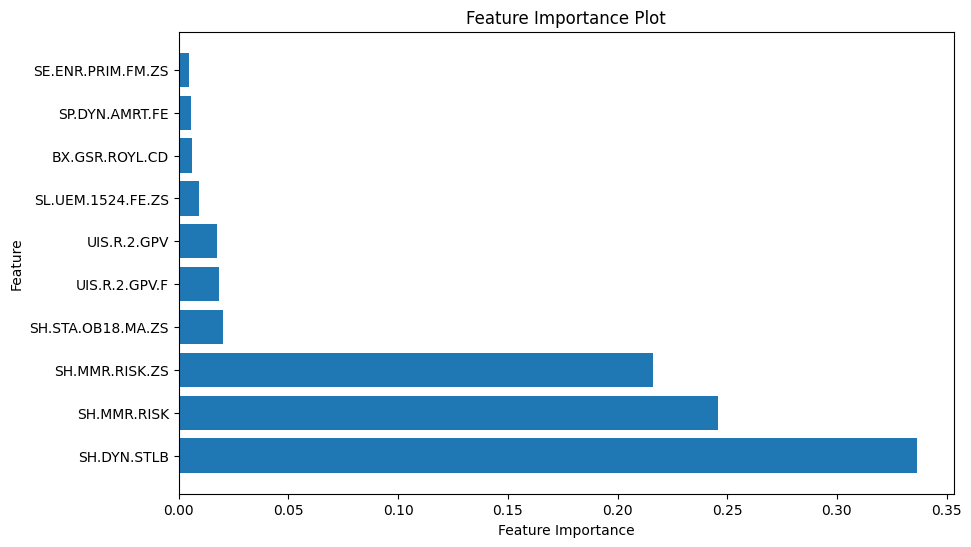

In [304]:
# Sort features by importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1][:10] # pull only the top 10 features
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importance[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances)
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()